In [27]:
import yfinance as yf
import pandas as pd

# Define the currency pair and the time period
currency_pair = 'EURTWD=X'  # Yahoo Finance ticker for Euro to New Taiwanese Dollar
start_date = '2019-01-01'
end_date = '2023-11-22'  # Replace with the desired end date

# Download historical data
exchange_rate_data = yf.download(currency_pair, start=start_date, end=end_date)

# Print the first few rows of the data
print(exchange_rate_data.head())

# Save the data to a CSV file (optional)
exchange_rate_data.to_csv('exchange_rate_data.csv')

[*********************100%%**********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2019-01-01  34.027000  34.027000  34.027000  34.027000  34.027000       0
2019-01-02  34.027000  34.182999  34.027000  34.027000  34.027000       0
2019-01-03  34.182999  34.182999  34.069000  34.182999  34.182999       0
2019-01-04  34.069000  34.193001  34.069000  34.069000  34.069000       0
2019-01-07  34.193001  34.273998  34.193001  34.193001  34.193001       0


In [100]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load the dataset
# Assuming you have a CSV file with columns 'Date' and 'ExchangeRate'
# Adjust the file path accordingly
data = pd.read_csv('exchange_rate_data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data = data.loc['2022-11-2':'2023-11-22']

# Keep only the first date of every month
data_monthly = data.resample('MS').first()
data_monthly.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-11-01,31.728834,34.702362,31.722239,31.730385,31.730385,0
2022-12-01,31.776480,32.217815,31.776480,32.086151,32.086151,0
2023-01-01,32.791237,32.866611,32.646648,32.874981,32.874981,0
2023-02-01,32.498154,32.661598,32.448135,32.615448,32.615448,0
2023-03-01,32.412270,32.601173,32.339603,32.413639,32.413639,0


In [101]:
# Set functions
# Check for stationarity using the Augmented Dickey-Fuller test
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    # Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries['Adj Close'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)


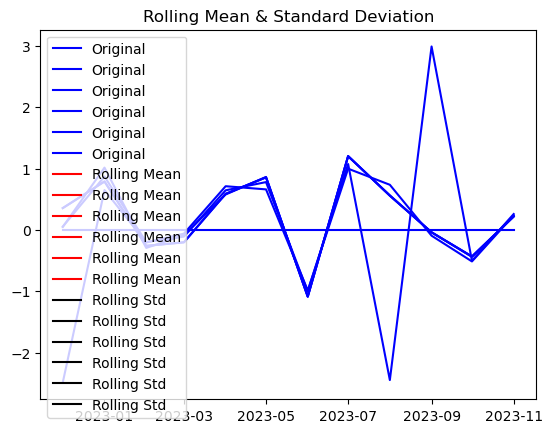

Results of Dickey-Fuller Test:
Test Statistic                -3.502035
p-value                        0.007935
#Lags Used                     2.000000
Number of Observations Used    9.000000
Critical Value (1%)           -4.473135
Critical Value (5%)           -3.289881
Critical Value (10%)          -2.772382
dtype: float64


In [102]:
# Make the time series stationary
data_diff = data_monthly.diff().dropna()

# Check stationarity
test_stationarity(data_diff)

ValueError: could not broadcast input array from shape (12,) into shape (21,)

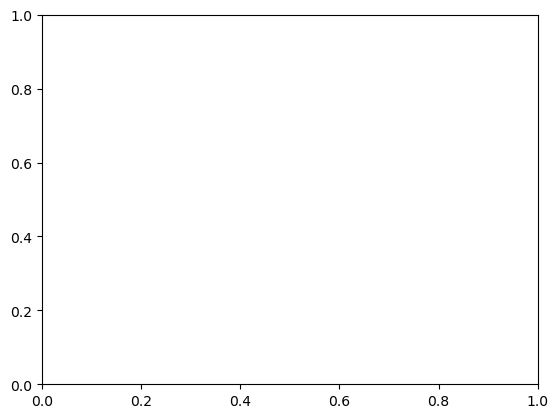

In [103]:
# Plot ACF and PACF to determine p and q values for ARIMA
plot_acf(data_diff['Adj Close'], lags=20)
plot_pacf(data_diff['Adj Close'], lags=20)
plt.show()

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                   13
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -11.457
Date:                Wed, 22 Nov 2023   AIC                             28.913
Time:                        19:22:22   BIC                             30.368
Sample:                    11-01-2022   HQIC                            28.374
                         - 11-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0286      1.070      0.027      0.979      -2.069       2.126
ma.L1         -0.3082      1.161     -0.265      0.791      -2.584       1.967
sigma2         0.3924      0.245      1.604      0.1

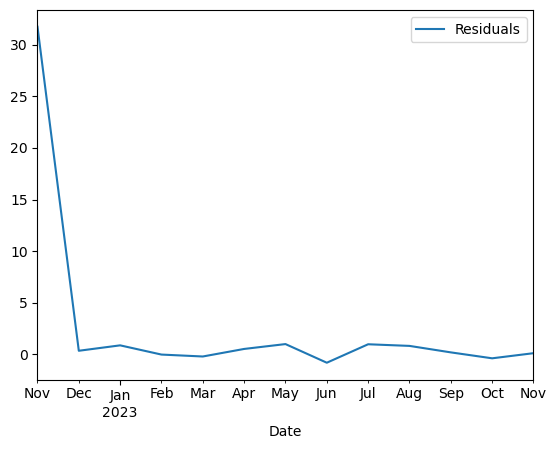

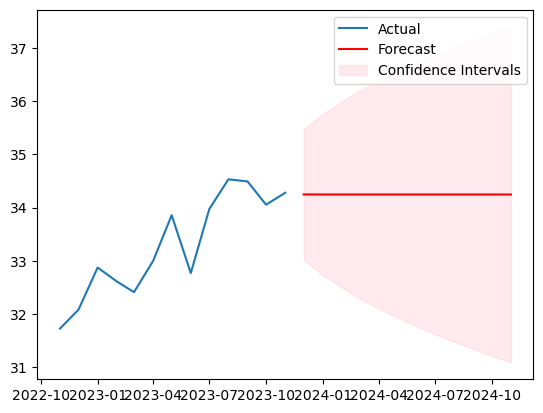

In [104]:
# Fit ARIMA model
# Adjust the order (p, d, q) based on the ACF and PACF plots
model = ARIMA(data_monthly['Adj Close'], order=(1, 1, 1))
results = model.fit()

# Print model summary
print(results.summary())

# Plot the residuals
residuals = pd.DataFrame(results.resid, columns=['Residuals'])
residuals.plot()
plt.show()

# Forecast the next 12 months
forecast_steps = 12
forecast = results.get_forecast(steps=forecast_steps)

# Get the predicted values and their confidence intervals
predicted_mean = forecast.predicted_mean
confidence_int = forecast.conf_int()

# Plot the actual values and the forecast with confidence intervals
plt.plot(data_monthly.index, data_monthly['Adj Close'], label='Actual')
plt.plot(predicted_mean.index, predicted_mean, color='red', label='Forecast')
plt.fill_between(confidence_int.index, confidence_int.iloc[:, 0], confidence_int.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Intervals')
plt.legend()
plt.show()

In [105]:
confidence_int


,lower Adj Close,upper Adj Close
2023-12-01,33.019476,35.475105
2024-01-01,32.733171,35.759649
2024-02-01,32.498531,35.994239
2024-03-01,32.292004,36.200764
2024-04-01,32.105310,36.387458
2024-05-01,31.933638,36.559130
2024-06-01,31.773857,36.718911
2024-07-01,31.623793,36.868975
2024-08-01,31.481863,37.010906
2024-09-01,31.346871,37.145897


In [ ]:
Í